In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import logging
from os import path
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from dstools import plot
from dstools.reproducibility import make_filename

import yass
from yass import util
from yass.augment import noise
from yass.augment.noise import noise_cov
from yass.augment.util import make_noise
from yass.neuralnetwork import NeuralNetDetector
from yass import detect

In [3]:
logging.basicConfig(level=logging.DEBUG)

In [4]:
# for reference
print('YASS version is: {}'.format(util.get_version()))

YASS version is: 107de20 improved logging


In [32]:
CONFIG = yass.set_config("config/gcloud/49/default.yaml")

path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

DEBUG:yass.config.config:Loaded from file: config/gcloud/49/default.yaml
DEBUG:yass:CONFIG set to: {'data': {'root_folder': '/home/Edu/data/retinal', 'recordings': 'ej49_data1_set1.bin', 'geometry': 'ej49_geometry1.txt'}, 'resources': {'max_memory': '50MB', 'max_memory_gpu': '10MB', 'processes': 'max'}, 'recordings': {'dtype': 'int16', 'sampling_rate': 20000, 'n_channels': 49, 'spatial_radius': 70, 'spike_size_ms': 2, 'order': 'samples'}, 'preprocess': {'apply_filter': True, 'dtype': 'float32', 'if_file_exists': 'skip', 'filter': {'order': 3, 'low_pass_freq': 300, 'high_factor': 0.1}}, 'detect': {'method': 'nn', 'temporal_features': 3, 'save_results': False, 'if_file_exists': 'skip', 'neural_network_detector': {'filename': '/home/Edu/dev/yass/src/yass/assets/models/detect_nn1.ckpt', 'threshold_spike': 0.5}, 'neural_network_triage': {'filename': '/home/Edu/dev/yass/src/yass/assets/models/triage_nn1.ckpt', 'threshold_collision': 0.5}, 'neural_network_autoencoder': {'filename': '/home/Edu

In [176]:
# predict on network
path_to_model = '/home/Edu/dev/yass/src/yass/assets/models/detect_nn1'
path_to_model = '/home/Edu/shengao-aug1/detect.ckpt'
path_to_model = '/home/Edu/dev/private-yass/nnet/models/detect/09-Aug-2018@02-02-17.ckpt'

model = NeuralNetDetector.load(path_to_model, 0.5, CONFIG.channel_index)

In [115]:
def any_nan(x):
    return np.isnan(x).any()

## Loading data

In [116]:
from yass.batch import RecordingsReader
from yass.geometry import order_channels_by_distance

logger = logging.getLogger(__name__)

# ##### FIXME: this needs to be removed, the user should already
# pass data with the desired channels
rec = RecordingsReader(path_to_standarized, loader='array')
channel_n_neighbors = np.sum(CONFIG.neigh_channels, 0)
max_neighbors = np.max(channel_n_neighbors)
channels_with_max_neighbors = np.where(channel_n_neighbors
                                       == max_neighbors)[0]
logger.debug('The following channels have %i neighbors: %s',
             max_neighbors, channels_with_max_neighbors)

# reference channel: channel with max number of neighbors
channel_selected = np.random.choice(channels_with_max_neighbors)

channel_selected = 25

logger.debug('Selected channel %i', channel_selected)

# neighbors for the reference channel
channel_neighbors = np.where(CONFIG.neigh_channels[channel_selected])[0]

# ordered neighbors for reference channel
channel_idx, _ = order_channels_by_distance(channel_selected,
                                            channel_neighbors,
                                            CONFIG.geom)
# read the selected channels
rec = rec[:, channel_idx]
# ##### FIXME:end of section to be removed

DEBUG:__main__:The following channels have 7 neighbors: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
DEBUG:__main__:Selected channel 25


In [117]:
rec.shape, type(rec)

((6000000, 7), numpy.ndarray)

In [118]:
channels_with_max_neighbors

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

## Passing noise snippets

In [119]:
(spatial_sig_small,
 temporal_sig_small) = noise_cov(rec,
                                 temporal_size=model.waveform_length,
                                 sample_size=1000,
                                 threshold=3.0,
                                 window_size=31)

DEBUG:yass.augment.noise:Starting to search noise snippets...
DEBUG:yass.augment.noise:Found 1/1000...
DEBUG:yass.augment.noise:Found 2/1000...
DEBUG:yass.augment.noise:Found 3/1000...
DEBUG:yass.augment.noise:Found 4/1000...
DEBUG:yass.augment.noise:Found 5/1000...
DEBUG:yass.augment.noise:Found 6/1000...
DEBUG:yass.augment.noise:Found 7/1000...
DEBUG:yass.augment.noise:Found 8/1000...
DEBUG:yass.augment.noise:Found 9/1000...
DEBUG:yass.augment.noise:Found 10/1000...
DEBUG:yass.augment.noise:Found 11/1000...
DEBUG:yass.augment.noise:Found 12/1000...
DEBUG:yass.augment.noise:Found 13/1000...
DEBUG:yass.augment.noise:Found 14/1000...
DEBUG:yass.augment.noise:Found 15/1000...
DEBUG:yass.augment.noise:Found 16/1000...
DEBUG:yass.augment.noise:Found 17/1000...
DEBUG:yass.augment.noise:Found 18/1000...
DEBUG:yass.augment.noise:Found 19/1000...
DEBUG:yass.augment.noise:Found 20/1000...
DEBUG:yass.augment.noise:Found 21/1000...
DEBUG:yass.augment.noise:Found 22/1000...
DEBUG:yass.augment.nois

DEBUG:yass.augment.noise:Found 193/1000...
DEBUG:yass.augment.noise:Found 194/1000...
DEBUG:yass.augment.noise:Found 195/1000...
DEBUG:yass.augment.noise:Found 196/1000...
DEBUG:yass.augment.noise:Found 197/1000...
DEBUG:yass.augment.noise:Found 198/1000...
DEBUG:yass.augment.noise:Found 199/1000...
DEBUG:yass.augment.noise:Found 200/1000...
DEBUG:yass.augment.noise:Found 201/1000...
DEBUG:yass.augment.noise:Found 202/1000...
DEBUG:yass.augment.noise:Found 203/1000...
DEBUG:yass.augment.noise:Found 204/1000...
DEBUG:yass.augment.noise:Found 205/1000...
DEBUG:yass.augment.noise:Found 206/1000...
DEBUG:yass.augment.noise:Found 207/1000...
DEBUG:yass.augment.noise:Found 208/1000...
DEBUG:yass.augment.noise:Found 209/1000...
DEBUG:yass.augment.noise:Found 210/1000...
DEBUG:yass.augment.noise:Found 211/1000...
DEBUG:yass.augment.noise:Found 212/1000...
DEBUG:yass.augment.noise:Found 213/1000...
DEBUG:yass.augment.noise:Found 214/1000...
DEBUG:yass.augment.noise:Found 215/1000...
DEBUG:yass.

DEBUG:yass.augment.noise:Found 384/1000...
DEBUG:yass.augment.noise:Found 385/1000...
DEBUG:yass.augment.noise:Found 386/1000...
DEBUG:yass.augment.noise:Found 387/1000...
DEBUG:yass.augment.noise:Found 388/1000...
DEBUG:yass.augment.noise:Found 389/1000...
DEBUG:yass.augment.noise:Found 390/1000...
DEBUG:yass.augment.noise:Found 391/1000...
DEBUG:yass.augment.noise:Found 392/1000...
DEBUG:yass.augment.noise:Found 393/1000...
DEBUG:yass.augment.noise:Found 394/1000...
DEBUG:yass.augment.noise:Found 395/1000...
DEBUG:yass.augment.noise:Found 396/1000...
DEBUG:yass.augment.noise:Found 397/1000...
DEBUG:yass.augment.noise:Found 398/1000...
DEBUG:yass.augment.noise:Found 399/1000...
DEBUG:yass.augment.noise:Found 400/1000...
DEBUG:yass.augment.noise:Found 401/1000...
DEBUG:yass.augment.noise:Found 402/1000...
DEBUG:yass.augment.noise:Found 403/1000...
DEBUG:yass.augment.noise:Found 404/1000...
DEBUG:yass.augment.noise:Found 405/1000...
DEBUG:yass.augment.noise:Found 406/1000...
DEBUG:yass.

DEBUG:yass.augment.noise:Found 575/1000...
DEBUG:yass.augment.noise:Found 576/1000...
DEBUG:yass.augment.noise:Found 577/1000...
DEBUG:yass.augment.noise:Found 578/1000...
DEBUG:yass.augment.noise:Found 579/1000...
DEBUG:yass.augment.noise:Found 580/1000...
DEBUG:yass.augment.noise:Found 581/1000...
DEBUG:yass.augment.noise:Found 582/1000...
DEBUG:yass.augment.noise:Found 583/1000...
DEBUG:yass.augment.noise:Found 584/1000...
DEBUG:yass.augment.noise:Found 585/1000...
DEBUG:yass.augment.noise:Found 586/1000...
DEBUG:yass.augment.noise:Found 587/1000...
DEBUG:yass.augment.noise:Found 588/1000...
DEBUG:yass.augment.noise:Found 589/1000...
DEBUG:yass.augment.noise:Found 590/1000...
DEBUG:yass.augment.noise:Found 591/1000...
DEBUG:yass.augment.noise:Found 592/1000...
DEBUG:yass.augment.noise:Found 593/1000...
DEBUG:yass.augment.noise:Found 594/1000...
DEBUG:yass.augment.noise:Found 595/1000...
DEBUG:yass.augment.noise:Found 596/1000...
DEBUG:yass.augment.noise:Found 597/1000...
DEBUG:yass.

DEBUG:yass.augment.noise:Found 766/1000...
DEBUG:yass.augment.noise:Found 767/1000...
DEBUG:yass.augment.noise:Found 768/1000...
DEBUG:yass.augment.noise:Found 769/1000...
DEBUG:yass.augment.noise:Found 770/1000...
DEBUG:yass.augment.noise:Found 771/1000...
DEBUG:yass.augment.noise:Found 772/1000...
DEBUG:yass.augment.noise:Found 773/1000...
DEBUG:yass.augment.noise:Found 774/1000...
DEBUG:yass.augment.noise:Found 775/1000...
DEBUG:yass.augment.noise:Found 776/1000...
DEBUG:yass.augment.noise:Found 777/1000...
DEBUG:yass.augment.noise:Found 778/1000...
DEBUG:yass.augment.noise:Found 779/1000...
DEBUG:yass.augment.noise:Found 780/1000...
DEBUG:yass.augment.noise:Found 781/1000...
DEBUG:yass.augment.noise:Found 782/1000...
DEBUG:yass.augment.noise:Found 783/1000...
DEBUG:yass.augment.noise:Found 784/1000...
DEBUG:yass.augment.noise:Found 785/1000...
DEBUG:yass.augment.noise:Found 786/1000...
DEBUG:yass.augment.noise:Found 787/1000...
DEBUG:yass.augment.noise:Found 788/1000...
DEBUG:yass.

DEBUG:yass.augment.noise:Found 957/1000...
DEBUG:yass.augment.noise:Found 958/1000...
DEBUG:yass.augment.noise:Found 959/1000...
DEBUG:yass.augment.noise:Found 960/1000...
DEBUG:yass.augment.noise:Found 961/1000...
DEBUG:yass.augment.noise:Found 962/1000...
DEBUG:yass.augment.noise:Found 963/1000...
DEBUG:yass.augment.noise:Found 964/1000...
DEBUG:yass.augment.noise:Found 965/1000...
DEBUG:yass.augment.noise:Found 966/1000...
DEBUG:yass.augment.noise:Found 967/1000...
DEBUG:yass.augment.noise:Found 968/1000...
DEBUG:yass.augment.noise:Found 969/1000...
DEBUG:yass.augment.noise:Found 970/1000...
DEBUG:yass.augment.noise:Found 971/1000...
DEBUG:yass.augment.noise:Found 972/1000...
DEBUG:yass.augment.noise:Found 973/1000...
DEBUG:yass.augment.noise:Found 974/1000...
DEBUG:yass.augment.noise:Found 975/1000...
DEBUG:yass.augment.noise:Found 976/1000...
DEBUG:yass.augment.noise:Found 977/1000...
DEBUG:yass.augment.noise:Found 978/1000...
DEBUG:yass.augment.noise:Found 979/1000...
DEBUG:yass.

In [120]:
n_noise_snippets = 1000000
noise_snippets = make_noise(n_noise_snippets, spatial_sig_small, temporal_sig_small)

DEBUG:dstools.plot.plot:Rows: 3, Cols: 3
DEBUG:dstools.plot.plot:Plotting in 0, 0
DEBUG:dstools.plot.plot:Plotting in 0, 1
DEBUG:dstools.plot.plot:Plotting in 0, 2
DEBUG:dstools.plot.plot:Plotting in 1, 0
DEBUG:dstools.plot.plot:Plotting in 1, 1
DEBUG:dstools.plot.plot:Plotting in 1, 2
DEBUG:dstools.plot.plot:Plotting in 2, 0
DEBUG:dstools.plot.plot:Plotting in 2, 1
DEBUG:dstools.plot.plot:Plotting in 2, 2


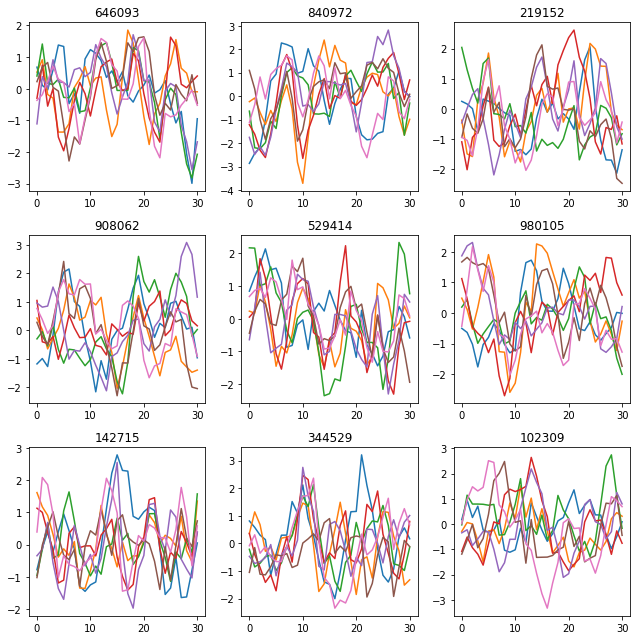

In [121]:
plot.grid_from_array(noise_snippets, axis=0, elements=9, auto_figsize=3)

In [122]:
predictions = model.predict(noise_snippets).astype(int)

DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/yass/src/yass/assets/models/detect_nn1.ckpt


In [123]:
wrong_predictions = noise_snippets[predictions == 1]

7

In [124]:
print(f'Error rate: {100 * predictions.sum()/n_noise_snippets:.2f}% ({predictions.sum()} out of {n_noise_snippets})')

Error rate: 0.00% (7 out of 1000000)


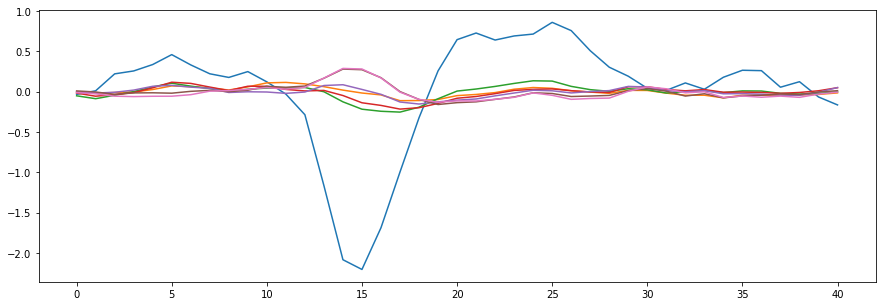

In [102]:
_ = plt.plot(wrong_predictions.mean(axis=0))

DEBUG:dstools.plot.plot:Rows: 3, Cols: 3
DEBUG:dstools.plot.plot:Plotting in 0, 0
DEBUG:dstools.plot.plot:Plotting in 0, 1
DEBUG:dstools.plot.plot:Plotting in 0, 2
DEBUG:dstools.plot.plot:Plotting in 1, 0
DEBUG:dstools.plot.plot:Plotting in 1, 1
DEBUG:dstools.plot.plot:Plotting in 1, 2
DEBUG:dstools.plot.plot:Plotting in 2, 0
DEBUG:dstools.plot.plot:Plotting in 2, 1
DEBUG:dstools.plot.plot:Plotting in 2, 2


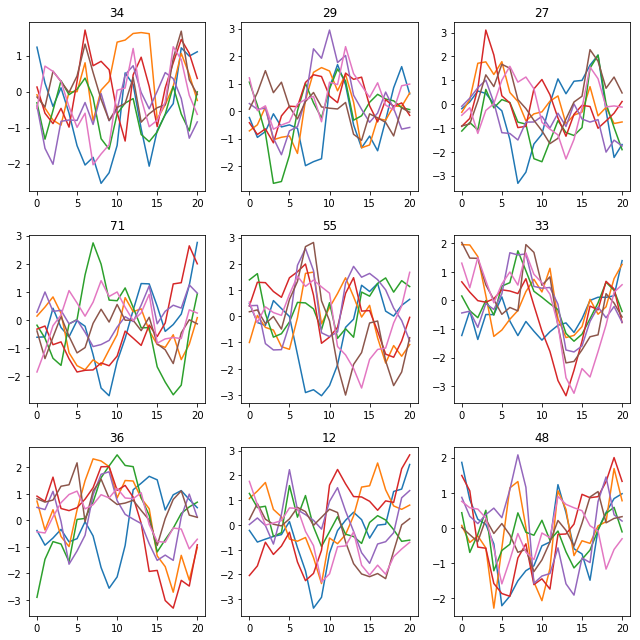

In [17]:
plot.grid_from_array(wrong_predictions, axis=0, elements=9, auto_figsize=3)

## Predicting on simulated noise recording

In [18]:
logging.basicConfig(level=logging.DEBUG)

In [138]:
# 25, 5000, 10
# 4, 5000, 10
# FIXME: select without replacement!!!!
spatial_SIG, temporal_SIG = noise_cov(rec,
                                      temporal_size=5000,
                                      window_size=31,
                                      sample_size=1000,
                                      threshold=3.0,
                                      max_trials_per_sample=100000,
                                      allow_smaller_sample_size=False)

DEBUG:yass.augment.noise:Starting to search noise snippets...
DEBUG:yass.augment.noise:Found 1/1000...
DEBUG:yass.augment.noise:Found 2/1000...
DEBUG:yass.augment.noise:Found 3/1000...
DEBUG:yass.augment.noise:Found 4/1000...
DEBUG:yass.augment.noise:Found 5/1000...
DEBUG:yass.augment.noise:Found 6/1000...
DEBUG:yass.augment.noise:Found 7/1000...
DEBUG:yass.augment.noise:Found 8/1000...
DEBUG:yass.augment.noise:Found 9/1000...
DEBUG:yass.augment.noise:Found 10/1000...
DEBUG:yass.augment.noise:Found 11/1000...
DEBUG:yass.augment.noise:Found 12/1000...
DEBUG:yass.augment.noise:Found 13/1000...
DEBUG:yass.augment.noise:Found 14/1000...
DEBUG:yass.augment.noise:Found 15/1000...
DEBUG:yass.augment.noise:Found 16/1000...
DEBUG:yass.augment.noise:Found 17/1000...
DEBUG:yass.augment.noise:Found 18/1000...
DEBUG:yass.augment.noise:Found 19/1000...
DEBUG:yass.augment.noise:Found 20/1000...
DEBUG:yass.augment.noise:Found 21/1000...
DEBUG:yass.augment.noise:Found 22/1000...
DEBUG:yass.augment.nois

DEBUG:yass.augment.noise:Found 193/1000...
DEBUG:yass.augment.noise:Found 194/1000...
DEBUG:yass.augment.noise:Found 195/1000...
DEBUG:yass.augment.noise:Found 196/1000...
DEBUG:yass.augment.noise:Found 197/1000...
DEBUG:yass.augment.noise:Found 198/1000...
DEBUG:yass.augment.noise:Found 199/1000...
DEBUG:yass.augment.noise:Found 200/1000...
DEBUG:yass.augment.noise:Found 201/1000...
DEBUG:yass.augment.noise:Found 202/1000...
DEBUG:yass.augment.noise:Found 203/1000...
DEBUG:yass.augment.noise:Found 204/1000...
DEBUG:yass.augment.noise:Found 205/1000...
DEBUG:yass.augment.noise:Found 206/1000...
DEBUG:yass.augment.noise:Found 207/1000...
DEBUG:yass.augment.noise:Found 208/1000...
DEBUG:yass.augment.noise:Found 209/1000...
DEBUG:yass.augment.noise:Found 210/1000...
DEBUG:yass.augment.noise:Found 211/1000...
DEBUG:yass.augment.noise:Found 212/1000...
DEBUG:yass.augment.noise:Found 213/1000...
DEBUG:yass.augment.noise:Found 214/1000...
DEBUG:yass.augment.noise:Found 215/1000...
DEBUG:yass.

DEBUG:yass.augment.noise:Found 384/1000...
DEBUG:yass.augment.noise:Found 385/1000...
DEBUG:yass.augment.noise:Found 386/1000...
DEBUG:yass.augment.noise:Found 387/1000...
DEBUG:yass.augment.noise:Found 388/1000...
DEBUG:yass.augment.noise:Found 389/1000...
DEBUG:yass.augment.noise:Found 390/1000...
DEBUG:yass.augment.noise:Found 391/1000...
DEBUG:yass.augment.noise:Found 392/1000...
DEBUG:yass.augment.noise:Found 393/1000...
DEBUG:yass.augment.noise:Found 394/1000...
DEBUG:yass.augment.noise:Found 395/1000...
DEBUG:yass.augment.noise:Found 396/1000...
DEBUG:yass.augment.noise:Found 397/1000...
DEBUG:yass.augment.noise:Found 398/1000...
DEBUG:yass.augment.noise:Found 399/1000...
DEBUG:yass.augment.noise:Found 400/1000...
DEBUG:yass.augment.noise:Found 401/1000...
DEBUG:yass.augment.noise:Found 402/1000...
DEBUG:yass.augment.noise:Found 403/1000...
DEBUG:yass.augment.noise:Found 404/1000...
DEBUG:yass.augment.noise:Found 405/1000...
DEBUG:yass.augment.noise:Found 406/1000...
DEBUG:yass.

DEBUG:yass.augment.noise:Found 575/1000...
DEBUG:yass.augment.noise:Found 576/1000...
DEBUG:yass.augment.noise:Found 577/1000...
DEBUG:yass.augment.noise:Found 578/1000...
DEBUG:yass.augment.noise:Found 579/1000...
DEBUG:yass.augment.noise:Found 580/1000...
DEBUG:yass.augment.noise:Found 581/1000...
DEBUG:yass.augment.noise:Found 582/1000...
DEBUG:yass.augment.noise:Found 583/1000...
DEBUG:yass.augment.noise:Found 584/1000...
DEBUG:yass.augment.noise:Found 585/1000...
DEBUG:yass.augment.noise:Found 586/1000...
DEBUG:yass.augment.noise:Found 587/1000...
DEBUG:yass.augment.noise:Found 588/1000...
DEBUG:yass.augment.noise:Found 589/1000...
DEBUG:yass.augment.noise:Found 590/1000...
DEBUG:yass.augment.noise:Found 591/1000...
DEBUG:yass.augment.noise:Found 592/1000...
DEBUG:yass.augment.noise:Found 593/1000...
DEBUG:yass.augment.noise:Found 594/1000...
DEBUG:yass.augment.noise:Found 595/1000...
DEBUG:yass.augment.noise:Found 596/1000...
DEBUG:yass.augment.noise:Found 597/1000...
DEBUG:yass.

DEBUG:yass.augment.noise:Found 766/1000...
DEBUG:yass.augment.noise:Found 767/1000...
DEBUG:yass.augment.noise:Found 768/1000...
DEBUG:yass.augment.noise:Found 769/1000...
DEBUG:yass.augment.noise:Found 770/1000...
DEBUG:yass.augment.noise:Found 771/1000...
DEBUG:yass.augment.noise:Found 772/1000...
DEBUG:yass.augment.noise:Found 773/1000...
DEBUG:yass.augment.noise:Found 774/1000...
DEBUG:yass.augment.noise:Found 775/1000...
DEBUG:yass.augment.noise:Found 776/1000...
DEBUG:yass.augment.noise:Found 777/1000...
DEBUG:yass.augment.noise:Found 778/1000...
DEBUG:yass.augment.noise:Found 779/1000...
DEBUG:yass.augment.noise:Found 780/1000...
DEBUG:yass.augment.noise:Found 781/1000...
DEBUG:yass.augment.noise:Found 782/1000...
DEBUG:yass.augment.noise:Found 783/1000...
DEBUG:yass.augment.noise:Found 784/1000...
DEBUG:yass.augment.noise:Found 785/1000...
DEBUG:yass.augment.noise:Found 786/1000...
DEBUG:yass.augment.noise:Found 787/1000...
DEBUG:yass.augment.noise:Found 788/1000...
DEBUG:yass.

DEBUG:yass.augment.noise:Found 957/1000...
DEBUG:yass.augment.noise:Found 958/1000...
DEBUG:yass.augment.noise:Found 959/1000...
DEBUG:yass.augment.noise:Found 960/1000...
DEBUG:yass.augment.noise:Found 961/1000...
DEBUG:yass.augment.noise:Found 962/1000...
DEBUG:yass.augment.noise:Found 963/1000...
DEBUG:yass.augment.noise:Found 964/1000...
DEBUG:yass.augment.noise:Found 965/1000...
DEBUG:yass.augment.noise:Found 966/1000...
DEBUG:yass.augment.noise:Found 967/1000...
DEBUG:yass.augment.noise:Found 968/1000...
DEBUG:yass.augment.noise:Found 969/1000...
DEBUG:yass.augment.noise:Found 970/1000...
DEBUG:yass.augment.noise:Found 971/1000...
DEBUG:yass.augment.noise:Found 972/1000...
DEBUG:yass.augment.noise:Found 973/1000...
DEBUG:yass.augment.noise:Found 974/1000...
DEBUG:yass.augment.noise:Found 975/1000...
DEBUG:yass.augment.noise:Found 976/1000...
DEBUG:yass.augment.noise:Found 977/1000...
DEBUG:yass.augment.noise:Found 978/1000...
DEBUG:yass.augment.noise:Found 979/1000...
DEBUG:yass.

In [139]:
noise_recording = make_noise(1, spatial_SIG, temporal_SIG)[0]

/home/Edu/dev/yass/src/yass/augment/util.py:312: ComplexWarning: Casting complex values to real discards the imaginary part
  noise[:, :, c] = np.matmul(noise[:, :, c], temporal_SIG)


In [140]:
filename = make_filename(str(noise_recording.shape[0])+'obs-', 'npy')
path_to_noise = str(Path(path_to_data, 'noise', filename))
print('saving', path_to_noise)
np.save(path_to_noise, noise_recording)

saving /home/Edu/data/noise/5000obs-15-Aug-2018@22-25-05.npy


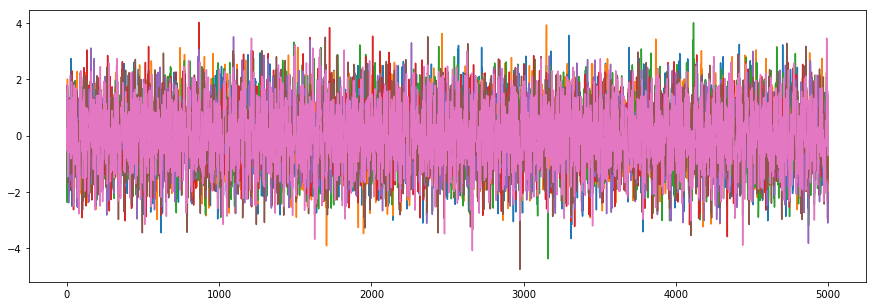

In [141]:
plt.rcParams['figure.figsize'] = (15, 5)
_ = plt.plot(noise_recording)

In [177]:
spike_index = model.predict_recording(noise_recording)[0]

DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/detect/09-Aug-2018@02-02-17.ckpt


In [178]:
spike_index.shape

(943, 2)

In [179]:
# duplicated?????
spike_index

array([[  24,    3],
       [  28,   12],
       [  36,    7],
       ...,
       [4947,    3],
       [4953,    1],
       [4955,    2]], dtype=int32)

In [180]:
noise_length, _ = noise_recording.shape
groups = int(noise_length/100)

In [181]:
def false_positives(slicer):
    sub = noise_recording[slicer]
    idx = model.predict_recording(sub)[0]
    return idx.shape[0]

In [182]:
slices = [slice(0, i*100) for i in range(1, groups + 1)]

In [183]:
sizes = [s.stop for s in slices]

In [184]:
n = [false_positives(s) for s in slices]

DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/detect/09-Aug-2018@02-02-17.ckpt
DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/detect/09-Aug-2018@02-02-17.ckpt
DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/detect/09-Aug-2018@02-02-17.ckpt
DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/detect/09-Aug-2018@02-02-17.ckpt
DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/detect/09-Aug-2018@02-02-17.ckpt
DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/detect/09-Aug-2018@02-02-17.ckpt
DEBUG:yass.neuralnetwork.model_detector:Restoring tensorflow session from: /home/Edu/dev/private-yass/nnet/models/dete

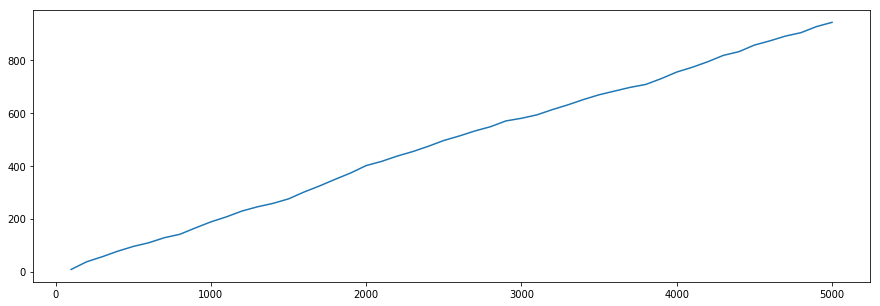

In [185]:
plt.plot(sizes, n)

In [186]:
seconds = [s/CONFIG.recordings.sampling_rate for s in sizes]

In [187]:
n_per_second = [an_n/sec for sec, an_n in zip(seconds, n)]

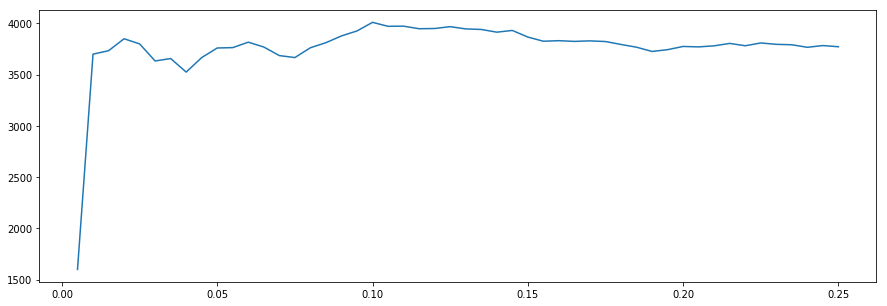

In [188]:
plt.plot(seconds, n_per_second)